# **Fine-tuning of YOLOv8-pose for macaque pose estimation**

Connect to drive and download dataset

In [ ]:
import os
import zipfile
import shutil
from google.colab import drive

drive.mount('/content/drive')
# shutil.copytree("/content/drive/Shareddrives/datasets/macaquepose", "/content/dataset") # tcopi dataset fl local bch fl manipulation mbaad tekel less time

!mkdir -p /content/drive/MyDrive/macaque-dataset
!wget -c "https://www2.ehub.kyoto-u.ac.jp/datasets/macaquepose/macaquepose_v1.zip" -O "/content/drive/MyDrive/macaque-dataset/macaquepose.zip"


--2025-05-05 21:38:17--  https://www2.ehub.kyoto-u.ac.jp/datasets/macaquepose/macaquepose_v1.zip
Resolving www2.ehub.kyoto-u.ac.jp (www2.ehub.kyoto-u.ac.jp)... 133.3.197.51
Connecting to www2.ehub.kyoto-u.ac.jp (www2.ehub.kyoto-u.ac.jp)|133.3.197.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20679639960 (19G) [application/zip]
Saving to: ‘/content/drive/MyDrive/macaque-dataset/macaquepose.zip’

/content/drive/MyDr 100%[===================>]  19.26G  34.1MB/s    in 9m 35s  

2025-05-05 21:47:52 (34.3 MB/s) - ‘/content/drive/MyDrive/macaque-dataset/macaquepose.zip’ saved [20679639960/20679639960]



In [ ]:
zip_path = "/content/drive/MyDrive/macaque-dataset/macaquepose.zip"
extract_path = "/content/drive/MyDrive/macaque-dataset/macaquepose"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
os.remove(zip_path)
print("Dataset extracted successfully!")

Dataset extracted successfully!


In [ ]:
import os
import pandas as pd
import numpy as np
import json
import shutil
import random
import json
import cv2
from google.colab import drive

drive.mount('/content/drive')

Data Exploration

In [ ]:
annotations = pd.read_csv("/content/drive/MyDrive/macaque-dataset/macaquepose/v1/annotations.csv")
print(annotations.iloc[0]["image file name"])
print(annotations.iloc[0]["keypoinbts"])
print(annotations.iloc[0]["segmentation"])

01418849d54b3005.jpg
[[{"name": "nose", "position": [2337, 1161]}, {"name": "left eye", "position": [1972, 913]}, {"name": "right eye", "position": [1752.3, 1021.68]}, {"name": "left ear", "position": null}, {"name": "right ear", "position": [1027, 1675]}, {"name": "left shoulder", "position": null}, {"name": "right shoulder", "position": [1536, 2680]}, {"name": "left elbow", "position": null}, {"name": "right elbow", "position": [2652, 3285]}, {"name": "left wrist", "position": null}, {"name": "right wrist", "position": [3069, 1823]}, {"name": "left hip", "position": null}, {"name": "right hip", "position": null}, {"name": "left knee", "position": null}, {"name": "right knee", "position": null}, {"name": "left ankle", "position": null}, {"name": "right ankle", "position": null}]]
[[{"segment":[[172.26,3124.44],[184.14,2863.08],[368.28,2589.84],[546.48,2381.94],[718.74,2203.74],[748.44,2025.54],[665.28,1865.16],[594,1681.02],[510.84,1580.04],[498.96,1437.48],[629.64,1366.2],[772.2,1081

Conversion to YOLO format

Pour chaque image :
Les keypoints sont normalisés entre [0, 1] en divisant leurs coordonnées (x, y) par la largeur et la hauteur de l'image et un bounding box est calculée autour des keypoints visibles.

Le fichier .txt généré contient une ligne par image au format suivant :
**class_id x_center y_center width height x1 y1 v1 x2 y2 v2 ... xk yk vk**

In [ ]:
CLASS_ID = 0
IMAGE_DIR = "/content/drive/MyDrive/macaque-dataset/macaquepose/v1/images"
OUTPUT_DIR = "/content/drive/MyDrive/macaque-dataset/macaquepose/v1/yolo_labels"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def process_row(row):
    image_filename = row["image file name"]
    keypoints_data = json.loads(row["keypoinbts"])

    image_path = os.path.join(IMAGE_DIR, image_filename)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Unable to load {image_path}")
        return

    img_h, img_w, _ = image.shape

    # note that handling visibility is only valuable
    # for visualisation purposes, not for training, still
    # lezem ll yolo format
    keypoints = []
    has_invalid_coordinates = False

    for kp in keypoints_data[0]:  # aana akther men instance
        if kp["position"] is not None:
            x, y = kp["position"]
            x_norm = x / img_w
            y_norm = y / img_h
            if x_norm > 1 or y_norm > 1:
              print(f"\nRaw keypoint: ({x}, {y}) | Image Size: ({img_w}, {img_h}) | Normalized: ({x_norm}, {y_norm})")
              has_invalid_coordinates = True
              break
            keypoints.append((x_norm, y_norm, 2))
        else:
            keypoints.append((0, 0, 0))

    # Bounding box
    if has_invalid_coordinates or not keypoints:
        print(f"Warning: No valid keypoints for {image_filename}")
        return

    keypoints_np = np.array([kp[:2] for kp in keypoints])  # Extract (x, y) only
    x_min, y_min = np.min(keypoints_np, axis=0)
    x_max, y_max = np.max(keypoints_np, axis=0)

    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    width = x_max - x_min
    height = y_max - y_min

    # YOLO format
    yolo_data = f"{CLASS_ID} {x_center} {y_center} {width} {height}"
    for kp in keypoints:
        yolo_data += f" {kp[0]} {kp[1]} {kp[2]}"  # x, y, visibility

    yolo_filename = os.path.join(OUTPUT_DIR, image_filename.replace(".jpg", ".txt"))
    with open(yolo_filename, "w") as f:
        f.write(yolo_data + "\n")

for _, row in annotations.iterrows():
    process_row(row)

print("YOLO annotations generated successfully!")


Raw keypoint: (2652, 3285) | Image Size: (4752, 3168) | Normalized: (0.5580808080808081, 1.0369318181818181)


skipped images are those that were cropped after annotating keypoints

Train/Test Splitting

In [ ]:
# Paths
image_dir = "/content/drive/MyDrive/macaque-dataset/macaquepose/v1/images"
label_dir = "/content/drive/MyDrive/macaque-dataset/macaquepose/v1/yolo_labels"
output_dir = "/content/drive/MyDrive/macaque-dataset/macaquepose/yolov"

# Create train/val directories
for split in ["train", "val"]:
    os.makedirs(os.path.join(output_dir, "images", split), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "labels", split), exist_ok=True)

# Get all image files
image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
random.shuffle(image_files)

# Define split ratio
train_ratio = 0.8
train_count = int(len(image_files) * train_ratio)

# Split dataset
train_files = image_files[:train_count]
val_files = image_files[train_count:]

# Function to move files
def move_files(files, split):
    for file in files:
        img_src = os.path.join(image_dir, file)
        label_src = os.path.join(label_dir, file.replace(".jpg", ".txt"))

        img_dest = os.path.join(output_dir, "images", split, file)
        label_dest = os.path.join(output_dir, "labels", split, file.replace(".jpg", ".txt"))

        shutil.move(img_src, img_dest)  # Move image
        if os.path.exists(label_src):
            shutil.move(label_src, label_dest)  # Move label

# Move files to train and val folders
move_files(train_files, "train")
move_files(val_files, "val")

print("Dataset successfully split into train and validation sets!")

Dataset successfully split into train and validation sets!


**Modeling**

In [2]:
!pip install ultralytics

from ultralytics import YOLO
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Check if data is imported successfully

In [ ]:
# Path to the directory
directory_path = "/content/drive/MyDrive/macaque-dataset/macaquepose/yolov/images/train"

# Get the list of files in the directory
try:
    files = os.listdir(directory_path)
    print(f"Number of files in '{directory_path}': {len(files)}")
except FileNotFoundError:
    print(f"Directory '{directory_path}' not found.")

Number of files in '/content/drive/MyDrive/macaque-dataset/macaquepose/yolov/images/train': 10466


Vu qu'une seule epoch prend déjà beaucoup de temps, on enregistre le modele automatiquement pour reprendre le training

In [3]:
model = YOLO("yolov8n-pose.pt")

# model = YOLO("/content/best.pt")

model.train(
    data="/content/drive/MyDrive/macaque-dataset/macaquepose/yolov/macaquepose.yaml",
    epochs=70,
    imgsz=640,
    batch=8,
    workers=2,
    save_period=1
    # resume=True,
)

100%|██████████| 6.52M/6.52M [00:00<00:00, 162MB/s]


Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/macaque-dataset/macaquepose/yolov/macaquepose.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-pose.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, persp

100%|██████████| 755k/755k [00:00<00:00, 27.6MB/s]


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

 22        [15, 18, 21]  1   1035934  ultralytics.nn.modules.head.Pose             [1, [17, 3], [64, 128, 256]]  
YOLOv8n-pose summary: 144 layers, 3,295,470 parameters, 3,295,454 gradients, 9.3 GFLOPs

Transferred 397/397 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
train: Fast image access ✅ (ping: 171.4±236.5 ms, read: 1.8±1.4 MB/s, size: 1567.0 KB)


train: Scanning /content/drive/.shortcut-targets-by-id/1MgwvloyyLReAa-q2RWg2dQ2pwEwnvOkD/macaque-dataset/macaquepose/yolov/labels/train.cache... 10415 images, 51 backgrounds, 8 corrupt: 100%|██████████| 10466/10466 [00:00<?, ?it/s]

train: /content/drive/.shortcut-targets-by-id/1MgwvloyyLReAa-q2RWg2dQ2pwEwnvOkD/macaque-dataset/macaquepose/yolov/images/train/PRI_0674.jpg: ignoring corrupt image/label: negative label values [ -0.0016711]
train: /content/drive/.shortcut-targets-by-id/1MgwvloyyLReAa-q2RWg2dQ2pwEwnvOkD/macaque-dataset/macaquepose/yolov/images/train/PRI_0973.jpg: ignoring corrupt image/label: negative label values [ -0.0010027]
train: /content/drive/.shortcut-targets-by-id/1MgwvloyyLReAa-q2RWg2dQ2pwEwnvOkD/macaque-dataset/macaquepose/yolov/images/train/ZooA_0659.jpg: ignoring corrupt image/label: negative label values [-0.00033422]
train: /content/drive/.shortcut-targets-by-id/1MgwvloyyLReAa-q2RWg2dQ2pwEwnvOkD/macaque-dataset/macaquepose/yolov/images/train/ZooA_0670.jpg: ignoring corrupt image/label: negative label values [ -0.0005144]
train: /content/drive/.shortcut-targets-by-id/1MgwvloyyLReAa-q2RWg2dQ2pwEwnvOkD/macaque-dataset/macaquepose/yolov/images/train/ZooC_0682.jpg: ignoring corrupt image/label

WARNING ⚠️ No 'flip_idx' array defined in data.yaml, setting augmentation 'fliplr=0.0'
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.9±0.2 ms, read: 2.3±0.4 MB/s, size: 1888.1 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1MgwvloyyLReAa-q2RWg2dQ2pwEwnvOkD/macaque-dataset/macaquepose/yolov/labels/val.cache... 2609 images, 8 backgrounds, 0 corrupt: 100%|██████████| 2617/2617 [00:00<?, ?it/s]


Plotting labels to runs/pose/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/pose/train
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       1/70         0G     0.8994      3.657     0.4388     0.9983      1.349          7        640: 100%|██████████| 1308/1308 [6:19:44<00:00, 17.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 164/164 [1:01:41<00:00, 22.57s/it]

                   all       2617       2609      0.829      0.848      0.891      0.731      0.797      0.778      0.809      0.424



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


       2/70         0G     0.6915      2.958     0.3818     0.7645      1.192         17        640:  34%|███▍      | 447/1308 [1:40:07<3:12:52, 13.44s/it]

Lors du premier epoch, les pertes initiales sont relativement élevées, notamment pour les keypoints (pose_loss = 3.657), ce qui est attendu en début de phase d’apprentissage. Malgré cela, les résultats sur le jeu de validation sont déjà encourageants : la précision moyenne pour la détection des objets atteint 89.1% (mAP@50) et celle des keypoints 80.9% (mAP@50), avec une mAP plus stricte (0.5–0.95) de 42.4% pour les poses.

***Model final***

In [ ]:
model = YOLO("/content/best.pt")

image_path = "/content/drive/MyDrive/macaque-dataset/macaquepose/yolov/images/val/020a1c75c8c85238.jpg"
results = model.predict(source=image_path, imgsz=640, save=False)


image 1/1 /content/drive/MyDrive/macaque-dataset/macaquepose/yolov/images/val/020a1c75c8c85238.jpg: 544x640 1 monkey, 88.0ms
Speed: 5.1ms preprocess, 88.0ms inference, 12.6ms postprocess per image at shape (1, 3, 544, 640)


***Predcition***

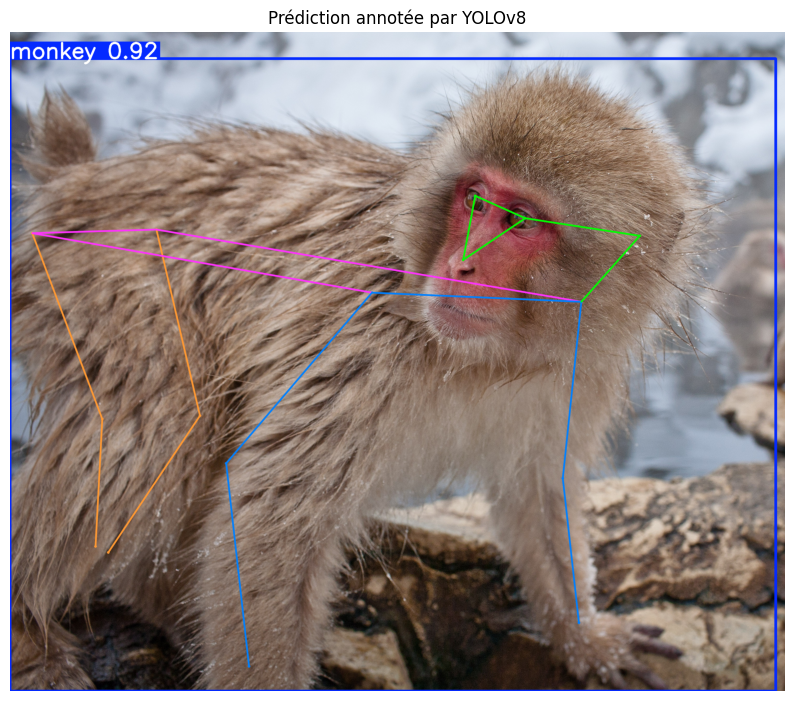

In [ ]:
import matplotlib.pyplot as plt
import cv2

annotated_img = results[0].plot()
annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(annotated_img_rgb)
plt.axis('off')
plt.title("Prédiction annotée par YOLOv8")
plt.show()